In [1]:
import matplotlib.pyplot as plt

import skimage.io as io
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import threshold_mean, sobel
from skimage.color import rgb2gray
import numpy as np
import pandas as pd
from typing import Tuple, List, Union
import sys
sys.path.insert(0, '..')
from utils.classic_image_utils import *
from utils.eye_dataset import *
from typing import Callable, Tuple, List


base_dir = "../../data"
image_dir = f"{base_dir}/preprocessed_images"
csv_file = f'{base_dir}/ODIR-5K/data.csv'


In [2]:
def print_diagnostics_from_tensor(labels, diagnostics: torch.Tensor):
    first = True
    for i in range(0, len(labels)):
        if not first:
            print(",", end="")
        if diagnostics[i] == 1:
            print(labels[i], end="")
    print()


### The Training Dataset

We use the utility class EyeImageDataset() to load the training dataset based on the metadata CSV file and
the target image folder

The training images will be loaded as needed due to memory constraints.

In [3]:
ds = EyeImageDataset(root=image_dir, data_info_csv_file=csv_file)

### Opacity / cataract detection

Here we can se two of the diagnostics categories in practice.
The first image shows a normal fundus eye while the second image shows a opaque fundus, displaying symptoms of cataract


Our proposal of opacity detection algorthim is to count pixels that belong to a border, using canny border detection, adjusted by a brigness equalization to reduce specularity effects

Normal eye opacity detected: False
Labeled diagnostics: Normal

Cataract eye opacity detected: True
Labeled diagnostics: Cataract


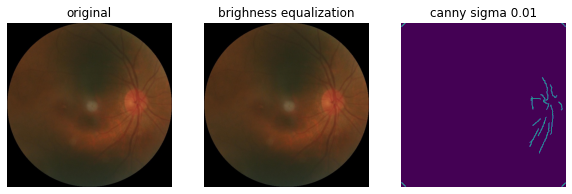

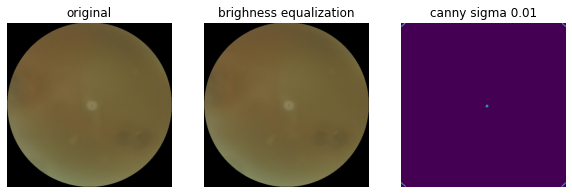

In [4]:
cataract, diag_cataract = ds.__getitem__(0)
normal, diag_normal = ds.__getitem__(1)

opacity = detect_opacity(normal, verbose=True, result_title=None)
print (f"Normal eye opacity detected: {opacity}" )
print ("Labeled diagnostics: ", end="")
print_diagnostics_from_tensor(ds.classes, diag_normal)

opacity = detect_opacity(cataract, verbose=True, result_title=None)
print (f"\nCataract eye opacity detected: {opacity}" )
print ("Labeled diagnostics: ", end="")
print_diagnostics_from_tensor(ds.classes, diag_cataract)

### Testing

For testing, we decided to classify our results into 4 possible categories:

- True positives, for the correct detections.

- False positives, for fundus images that the algorithm classified as cataract while they were something else

- True negatives, for the correct no-cataract detections.

- False negatives, for fundus images that the algorithm should have classified as cataract but didn't


In [5]:
def test_cataract_detection(detection_method:Callable, ds: EyeImageDataset) -> Tuple[List, List]:
    false_positive_cataract_count = 0
    true_positive_cataract_count = 0
    true_negative_cataract_count = 0
    false_negative_cataract_count = 0
    total_cataract_diags = 0
    total_no_cataract_diags = 0

    false_positive_pos = []
    false_negative_pos = []

    for i in range(0, ds.__len__()):
        img = ds.__read_image__(i)
        diag = ds.targets[i]
        opacity = detection_method(img, verbose=False, result_title=None)
        if (diag[3] == 1):
            if opacity: true_positive_cataract_count += 1
            else: 
                false_negative_cataract_count += 1
                false_negative_pos.append(i)

            total_cataract_diags += 1
        else:
            if opacity: 
                false_positive_cataract_count += 1
                false_positive_pos.append(i)
            else: true_negative_cataract_count += 1   

            total_no_cataract_diags += 1
    
    print (f'True positives: {true_positive_cataract_count}/{total_cataract_diags}: {100 * true_positive_cataract_count/total_cataract_diags:.2f} %')
    print (f'False positives: {false_positive_cataract_count}/{total_cataract_diags}: {100 * false_positive_cataract_count/total_cataract_diags:.2f} %')
    print ()
    print (f'True negatives: {true_negative_cataract_count}/{total_no_cataract_diags}: {100 * true_negative_cataract_count/total_no_cataract_diags:.2f} %')
    print (f'False negatives: {false_negative_cataract_count}/{total_no_cataract_diags}: {100 * false_negative_cataract_count/total_no_cataract_diags:.2f} %')

    return false_positive_pos, false_negative_pos


In [6]:
false_positive_pos, false_negative_pos = test_cataract_detection(detect_opacity, ds)



True positives: 198/286: 69.23 %
False positives: 133/286: 46.50 %

True negatives: 5863/5996: 97.78 %
False negatives: 88/5996: 1.47 %
